
# Data Cleaning Notebook – Heritage Housing Prices

## Objectives

This notebook prepares the dataset for machine learning modeling by:

- Identifying and evaluating missing values
- Creating a plan to handle missing values
- Splitting the data into training and testing sets
- Dropping sparse or non-predictive features
- Saving cleaned datasets for modeling

## Inputs

- Original dataset
  - outputs\datasets\collection\house_prices_records.csv

## Outputs

- Generate cleaned Train and Test sets:
  - outputs\datasets\cleaned\TrainSetCleaned.csv
  - outputs\datasets\cleaned\TestSetCleaned.csv


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os

current_dir = os.getcwd()
current_dir

'c:\\Users\\Arthur\\OneDrive\\Documentos\\Code Institute\\PP5\\PP5-heritage-housing-issues-ml\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* `os.path.dirname()` gets the parent directory
* `os.chir()` defines the new current directory

Then we confirm the new current directory by printing it with `os.getcwd()` again.

In [2]:
os.chdir(os.path.dirname(current_dir))
print("New working directory set to:", os.getcwd())

New working directory set to: c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml


---

# Load Collected data

In [3]:
import pandas as pd

df_raw_path = "outputs/datasets/collection/house_prices_records.csv"
df = pd.read_csv(df_raw_path)
df.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

# Data Exploration

In this section, we are interested in checking the distribution and shape of variables with missing data.

So we list all variables with missing data:

In [4]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data


['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtExposure',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

Then we create a profile with the variables with missing data

In [ ]:
from ydata_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

# Correlation and PPS Analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

%matplotlib inline


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman", numeric_only=True)
    df_corr_pearson = df.corr(method="pearson", numeric_only=True)

    import warnings

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning) # Ignore FutureWarning for ppscore to improve readability
        pps_matrix_raw = pps.matrix(df)
        pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

        pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
        print("\nPPS threshold - check PPS score IQR to decide threshold for heatmap \n")
        print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)


Calculate Correlations and Power Predictive Score

In [6]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(



PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%   75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.06  0.702


- 50% of all PPS are 0, that means that most feature-to-feature relationships show no predictive power

- 75% are below 0.06 → only 25% of relationships have a PPS above 0.06

- Only a few values go above 0.2

So by setting the threshold at 0.2, we're:

- Showing only the top ~5–10% of predictive relationships

- Highlighting strong signals

- Avoiding a cluttered heatmap

It aligns well with the IQR logic (75% of scores are below 0.06 — so 0.2 is well into the upper tail).

The histogram plots below highlight the threshold (red dashed line) in the distribution of PPS scores. The second plot is meant to highlight real variation by excluding 0.0 and 1.0. The histograms make it visually clear that only a small portion of the scores will be used for the heatmap.

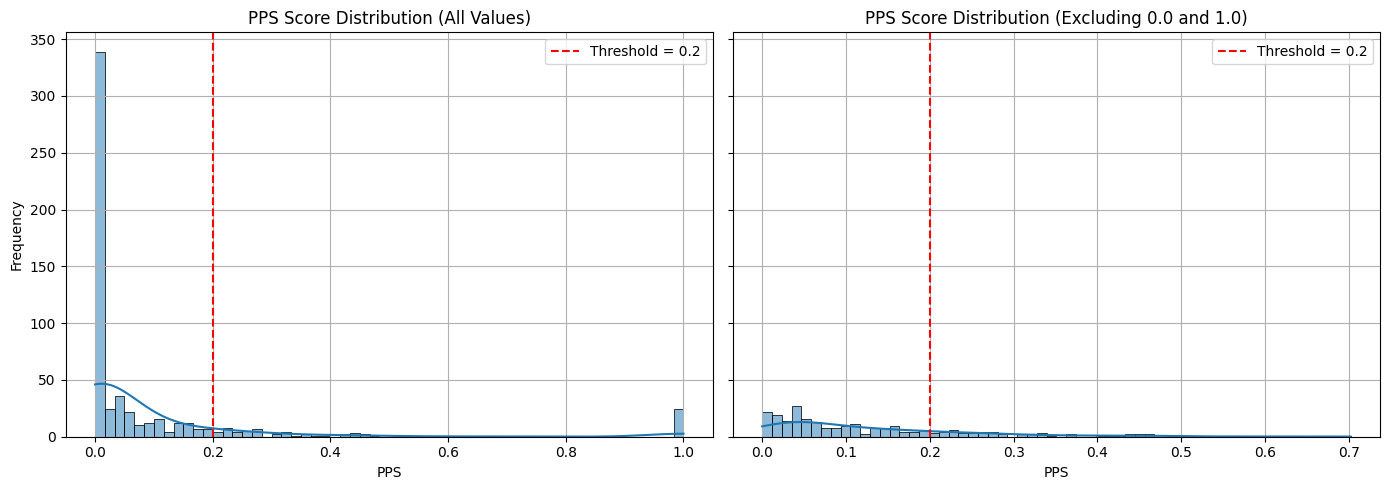

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Flatten the PPS matrix to extract all PPS scores and remove NaNs
pps_scores = pps_matrix.values.flatten()
pps_scores = pps_scores[~np.isnan(pps_scores)]

threshold = 0.2  # Define the threshold line

# Filtered version (excluding 0.0 and 1.0)
filtered_pps_scores = pps_scores[(pps_scores != 0.0) & (pps_scores != 1.0)]

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot 1: Full PPS distribution
sns.histplot(pps_scores, bins=60, kde=True, ax=axes[0])
axes[0].axvline(threshold, color='red', linestyle='--', label='Threshold = 0.2')
axes[0].set_title("PPS Score Distribution (All Values)")
axes[0].set_xlabel("PPS")
axes[0].set_ylabel("Frequency")
axes[0].legend()
axes[0].grid(True)

# Plot 2: Filtered PPS distribution
sns.histplot(filtered_pps_scores, bins=60, kde=True, ax=axes[1])
axes[1].axvline(threshold, color='red', linestyle='--', label='Threshold = 0.2')
axes[1].set_title("PPS Score Distribution (Excluding 0.0 and 1.0)")
axes[1].set_xlabel("PPS")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

Display Heatmaps



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



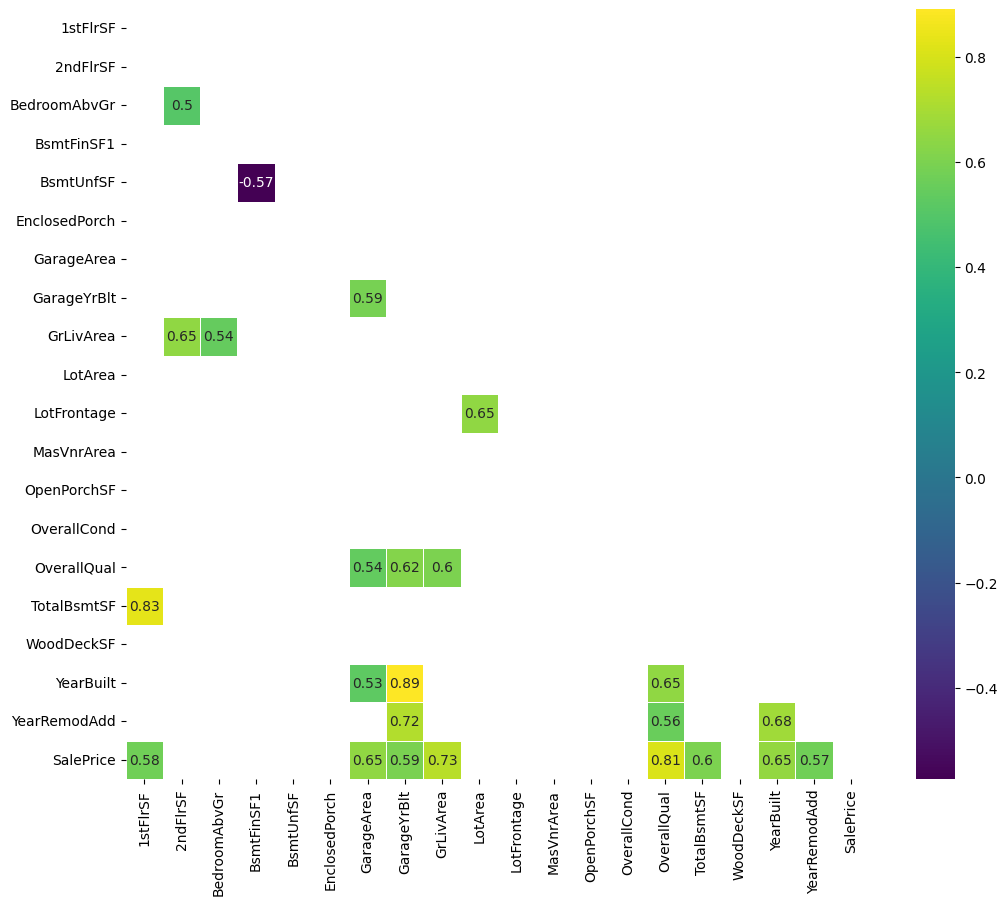



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



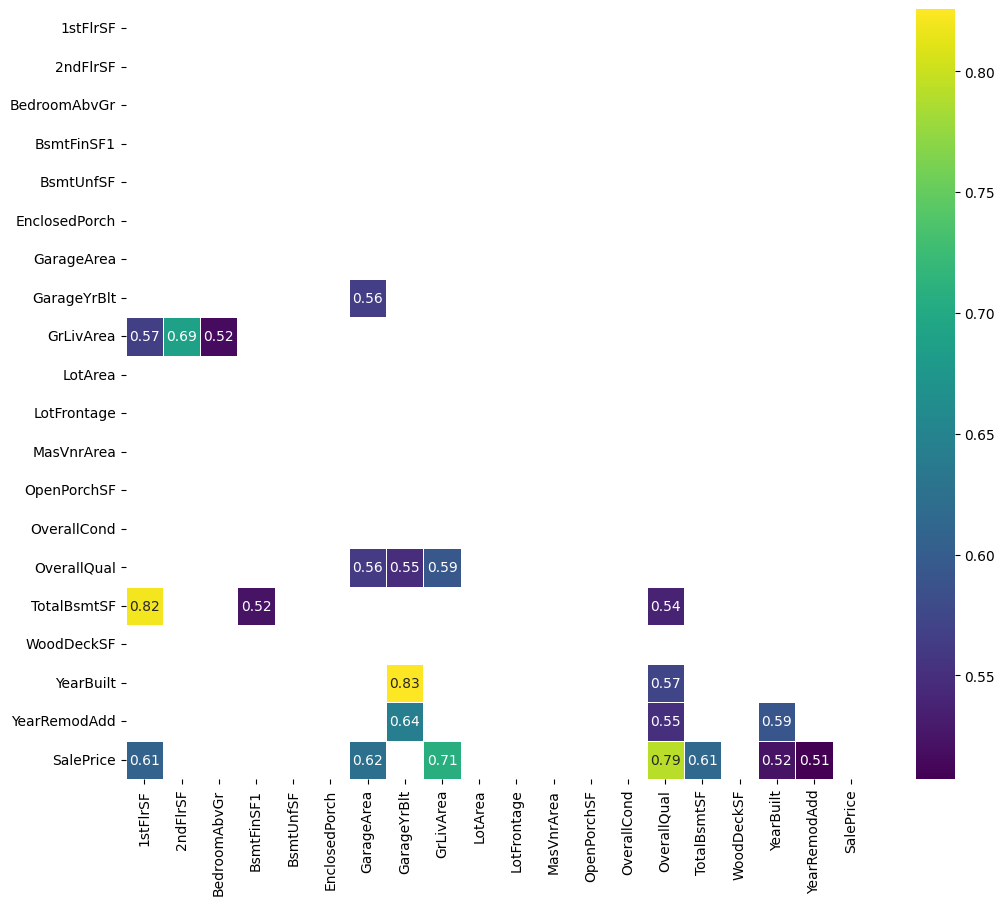



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



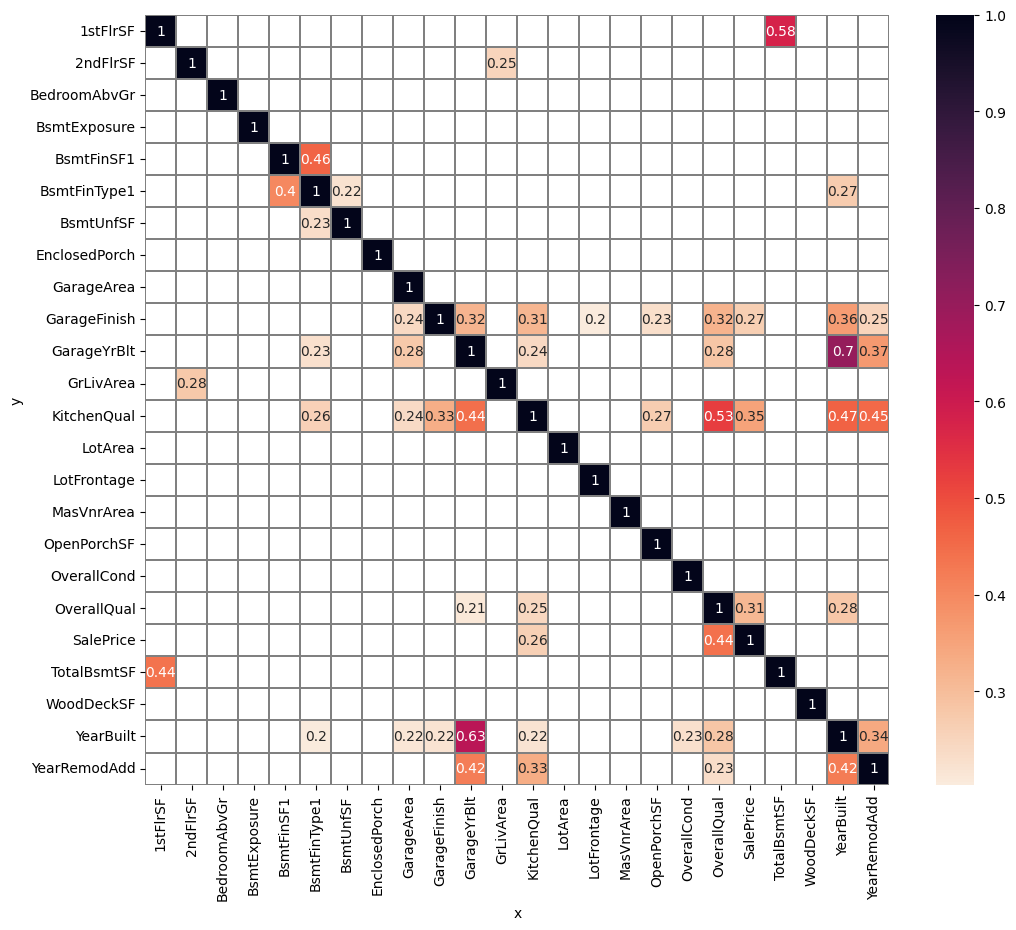


Features with correlation above the threshold to SalePrice:

['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallQual', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'SalePrice']


In [8]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.5, PPS_Threshold = 0.2,
                  figsize=(12,10), font_annot=10)

high_corr_features = df_corr_spearman['SalePrice'][df_corr_spearman['SalePrice'] > threshold].index.tolist()
print("\nFeatures with correlation above the threshold to SalePrice:\n")
print(high_corr_features)

### Top Predictors of SalePrice

| Features most correlated with sales price | Spearman  | Pearson | PPS |
|-------------------------------------------|-----------|---------|-----|
| `1stFlrSF`                                | ✅       | ✅      | ❌  |
| `GarageArea`                              | ✅       | ✅      | ❌  |
| `GarageYrBlt`                             | ✅       | ❌      | ❌  |
| `GrLivArea`                               | ✅       | ✅      | ❌  |
| `KitchenQual`                             | ❌       | ❌      | ✅  |
| `OverallQual`                             | ✅       | ✅      | ✅  |
| `TotalBsmtSF`                             | ✅       | ✅      | ❌  |
| `YearBuilt`                               | ✅       | ✅      | ❌  |
| `YearRemodAdd`                            | ✅       | ✅      | ❌  |

All three methods consistently highlight the following variables as highly predictive of house prices:

- `OverallQual` (Quality of materials/finish)

While both **Spearman** and **Person** put the following variables above the threshold:

- `1stFlrSF` (1st floor area in square feet)
- `GarageArea`
- `GrLivArea` (Above-ground living area)
- `TotalBsmtSF` (Basement area)
- `YearBuilt`
- `YearRemodAdd`

These features seem like good candidates to retain for model development.

### Multicollinearity Considerations

Some variables are strongly correlated with each other, which may cause multicollinearity in linear models:

- `GarageYrBuilt` ↔ `YearBuilt` (0.7)
- `YearBuilt` ↔ `GarageYrBuilt` (0.63)
- `1stFlrSF` ↔ `TotalBsmtSF` (0.58)
- `GarageArea` ↔ `GrLivArea` (0.57)
- `KitchenQual` ↔ `OverallQual` (0.53)
- `KitchenQual` ↔ `YearBuilt` (0.47)

In all heatmaps, we observe that the features are correlated with each other and exhibit predictive power among themselves. As a result, they provide redundant information for predicting the target variable, which increases the risk of overfitting the model. To address this, the next notebook will include a step to eliminate any excessively correlated features.

---

# Data Cleaning

## Assessing Missing Data Levels

- Custom function to display missing data levels in a DataFrame, it shows the absolute levels, relative levels and data type.

In [9]:
def evaluate_missing_data(df):
    missing_abs = df.isnull().sum()
    missing_pct = round(missing_abs / len(df) * 100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_abs,
                                   "PercentageOfDataset": missing_pct,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

Check missing data levels for the collected dataset.

In [10]:
evaluate_missing_data(df)
print("\n")
print(evaluate_missing_data(df))



               RowsWithMissingData  PercentageOfDataset DataType
EnclosedPorch                 1324                90.68  float64
WoodDeckSF                    1305                89.38  float64
LotFrontage                    259                17.74  float64
GarageFinish                   235                16.10   object
BsmtFinType1                   145                 9.93   object
BedroomAbvGr                    99                 6.78  float64
2ndFlrSF                        86                 5.89  float64
GarageYrBlt                     81                 5.55  float64
BsmtExposure                    38                 2.60   object
MasVnrArea                       8                 0.55  float64


---

# Dealing with missing data

## Dropping Sparse Features

Based on the profiling report, we reviewed each variable with missing values and made decisions grounded in their:

- Missing percentage
- Predictive value potential
- Domain relevance

### Features to Drop:

- **`EnclosedPorch`** – 90.7% missing  
  Too sparse to be useful. Even if imputed, it would contribute noise rather than signal.

- **`WoodDeckSF`** – 89.4% missing  
  Very low coverage and low variability among non-missing values. Similar to `EnclosedPorch`, better removed.

These features are dropped to simplify the dataset and avoid bias or overfitting due to poor-quality data.

In [11]:
variables_to_drop = ['EnclosedPorch', 'WoodDeckSF']

print(f"Variables to drop: {variables_to_drop}")

Variables to drop: ['EnclosedPorch', 'WoodDeckSF']


## Impute Missing Values

Before any modeling or transformation can occur, it's essential to address missing data. This ensures model compatibility and avoids distortions during encoding and scaling. 

We begin by identifying variables with missing values and apply suitable imputation strategies based on the variable type and domain knowledge. Where relevant, we also add binary indicators to flag imputed values for potential predictive insight.
We apply imputation strategies based on data type and domain understanding.

We see that there are 64 instances of 'Zero' in `GarageArea` and 64 empty instances in `GarageYrBlt`, leading us to infer that the missing data in `GarageYrBlt` relates to the lack of a garage in that house.

We start by handling missing values before encoding or scaling. This includes:

- Using grouped median imputation for `LotFrontage`
- Using constant values where missingness signals absence
  - `0` for numeric features
  - `"None"` for categorical features 


### Imputation Plan

| Feature         | Rows With Missing Data | Percentage Of Dataset | Data Type | Metadata Insight                                         | Strategy       | Notes                                                                 |
|:---------------:|:-------------------:|:--------------------:|:--------:|:----------------:|:--------:|:-----:|
| `LotFrontage`   | 259                 | 17.74                | float64  | Linear feet of street connected to property               | Median         | Group median                                                          |
| `GarageYrBlt`   | 81                  | 5.55                 | float64  | Year garage was built (1900–2010); missing if no garage   | Fill with `0`  | 0 clearly means no garage (can also flag with new feature if needed) |
| `2ndFlrSF`      | 86                  | 5.89                 | float64  | Square footage of second floor (0–2065); 0 is common      | Fill with `0`  | No imputation needed — zero is valid                                 |
| `MasVnrArea`    | 8                   | 0.55                 | float64  | Masonry veneer area (0–1600); 0 means no veneer           | Fill with `0`  | 0 is semantically meaningful                                          |
| `BedroomAbvGr`  | 99                  | 6.78                 | float64  | Bedrooms above ground; 0–8 range                          | Median         | Could also test for mode; median is fine                             |
| `BsmtExposure`  | 38                  | 2.60                 | object   | Exposure rating or `"None"` for no basement               | Fill with `"None"` | Use `"None"` instead of "Missing" to match domain encoding           |
| `BsmtFinType1`  | 145                 | 9.93                 | object   | Finish type or `"None"` if no basement                    | Fill with `"None"` | `"None"` is an actual category in metadata                          |
| `GarageFinish`  | 235                 | 16.10                | object   | Garage interior finish or `"None"` if no garage           | Fill with `"None"` | Use `"None"` for clarity and alignment with domain semantics        |


## Split Train and Test Set

We split the dataset before cleaning to avoid data leakage.

This ensures that:

- All cleaning decisions (like which variables to drop) are based solely on the training data

- The test set remains a realistic “unseen” sample to evaluate model performance

- We simulate what would happen in a real-world deployment, where new data is cleaned using a process built on the training set

In [12]:
from sklearn.model_selection import train_test_split

TrainSet, TestSet = train_test_split(
    df,
    test_size=0.2,
    random_state=42
)

print(f"TrainSet shape: {TrainSet.shape}")
print(f"TestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24)
TestSet shape: (292, 24)


- We put together the feature drop, numerical and categorical impute steps in our pipeline.
- We create another DataFrame applying the imputations in the pipeline.

In [13]:

from sklearn.pipeline import Pipeline 
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.selection import DropFeatures
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

variables_to_drop = ['EnclosedPorch', 'WoodDeckSF']
numerical_impute_median = ['BedroomAbvGr', "LotFrontage"]
numerical_impute_zero = ['2ndFlrSF', 'MasVnrArea', 'GarageYrBlt']
categorical_fill_none = ['GarageFinish', 'BsmtFinType1', 'BsmtExposure']

pipeline = Pipeline([
    ('drop', DropFeatures(features_to_drop=variables_to_drop)),
    ('median', MeanMedianImputer(imputation_method='median', variables=numerical_impute_median)),
    ('zero', ArbitraryNumberImputer(arbitrary_number=0, variables=numerical_impute_zero)),
    ('cat', CategoricalImputer(imputation_method='missing', fill_value="None", variables=categorical_fill_none))
])


df_method = pipeline.fit_transform(TrainSet)

We then confirm that there's no missing values in the new DataFrame

In [14]:
df_method.isnull().sum()

1stFlrSF        0
2ndFlrSF        0
BedroomAbvGr    0
BsmtExposure    0
BsmtFinSF1      0
BsmtFinType1    0
BsmtUnfSF       0
GarageArea      0
GarageFinish    0
GarageYrBlt     0
GrLivArea       0
KitchenQual     0
LotArea         0
LotFrontage     0
MasVnrArea      0
OpenPorchSF     0
OverallCond     0
OverallQual     0
TotalBsmtSF     0
YearBuilt       0
YearRemodAdd    0
SalePrice       0
dtype: int64

Using a custom function, we assess the effect on the variable's distribution.

In [ ]:
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
    # first on variables that you applied the method
    # if the variable is a numerical plot, a histogram if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    
    print("\n")
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type": "Original", "Value": df_original[var].astype(str)})
        df2 = pd.DataFrame({"Type": "Cleaned", "Value": df_cleaned[var].astype(str)})

        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1

We put together the affected variables

In [16]:
variables_applied_with_method = numerical_impute_median + numerical_impute_zero + categorical_fill_none

print(variables_applied_with_method)

['BedroomAbvGr', 'LotFrontage', '2ndFlrSF', 'MasVnrArea', 'GarageYrBlt', 'GarageFinish', 'BsmtFinType1', 'BsmtExposure']





* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['BedroomAbvGr', 'LotFrontage', '2ndFlrSF', 'MasVnrArea', 'GarageYrBlt', 'GarageFinish', 'BsmtFinType1', 'BsmtExposure'] 




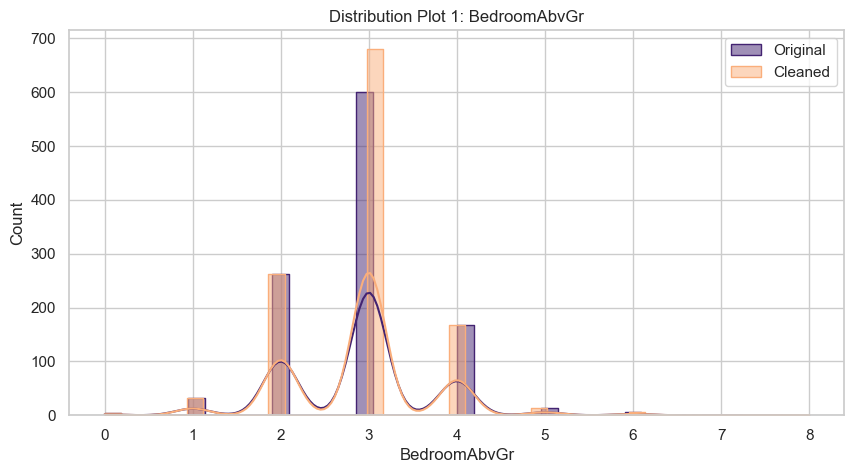

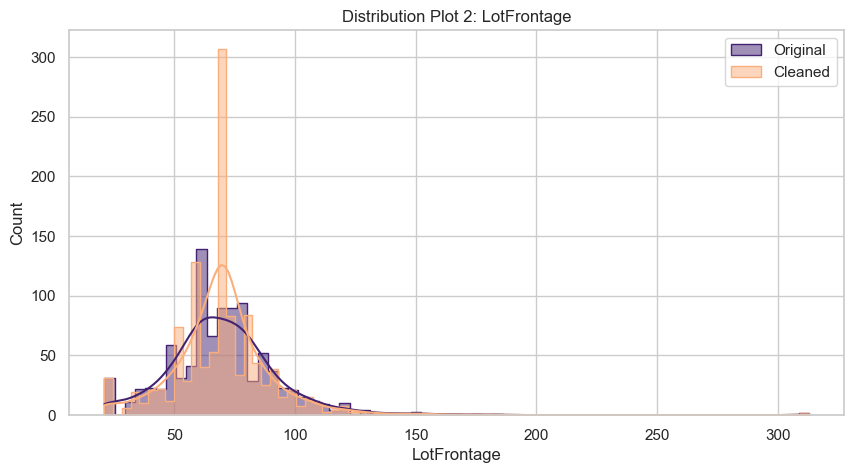

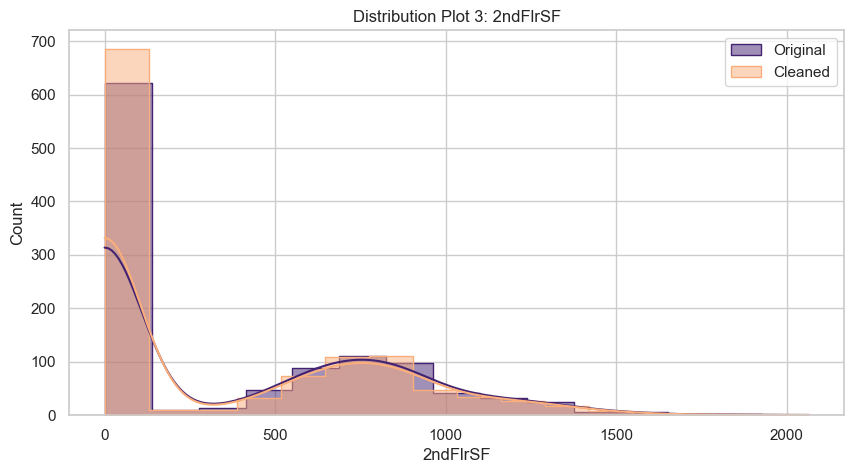

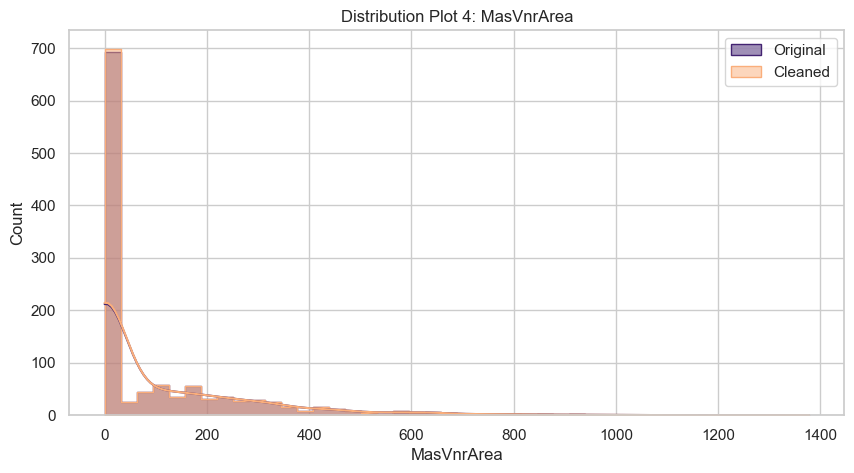

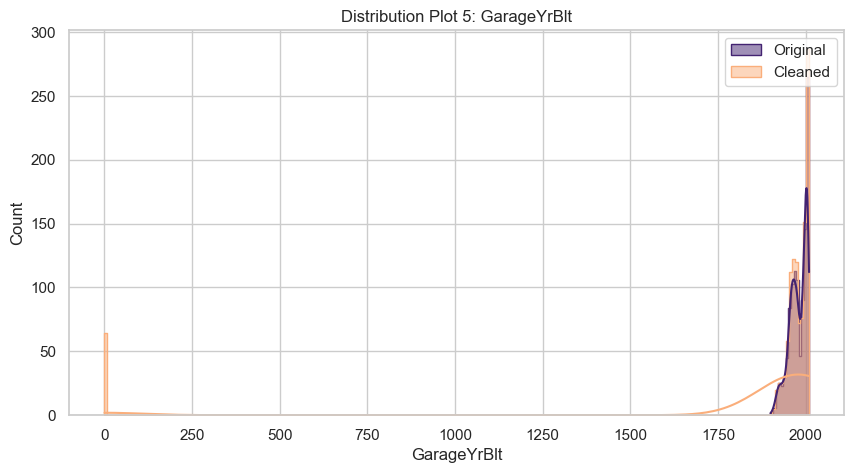

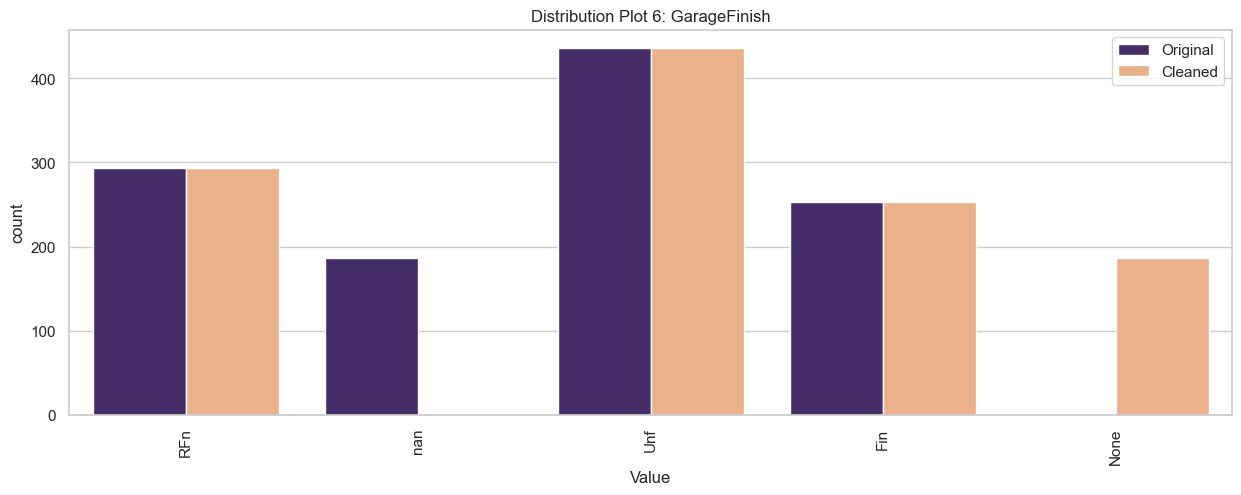

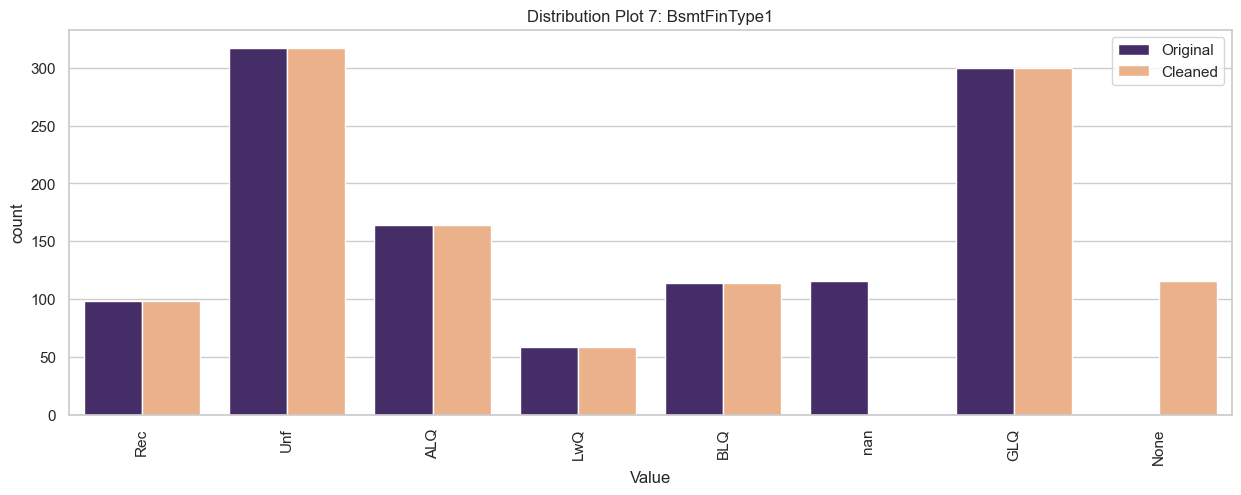

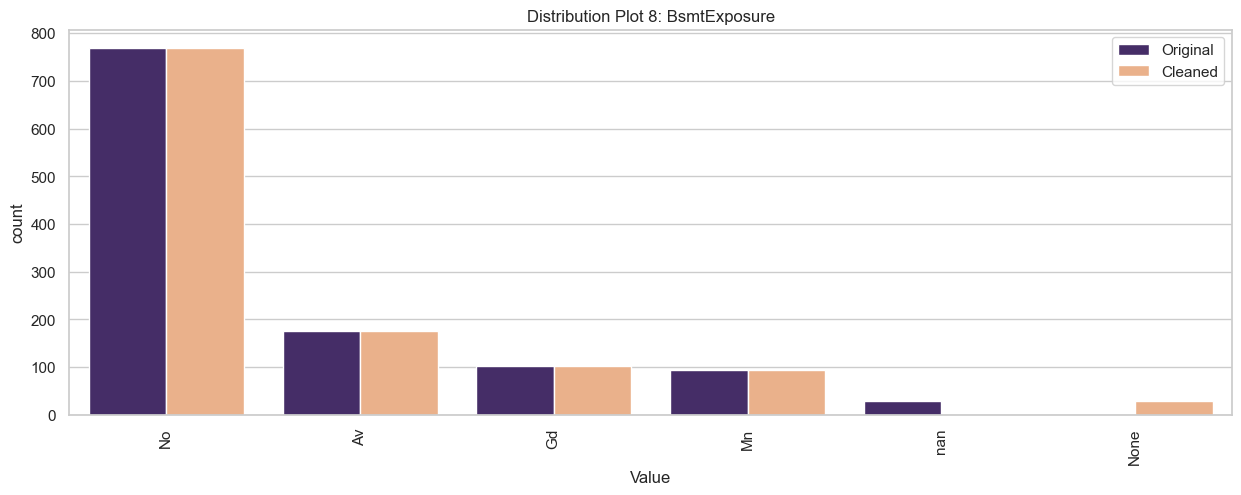

In [17]:
DataCleaningEffect(df_original=TrainSet, df_cleaned=df_method, variables_applied_with_method=variables_applied_with_method)


---

## Post-Imputation Correlation & PPS Check

Now that we've imputed missing values and added flags, we reassess the feature relationships.

This helps us:
- Re-confirm top predictors of `SalePrice`
- Detect any new multicollinearity

We'll examine both:
- **Pearson/Spearman correlation** (for linear and monotonic relationships)
- **Power Predictive Score (PPS)** (for general predictive strength)

In [18]:
# 1. Preview column data types
print("Column data types after imputation:")
print(df_method.dtypes.value_counts())

# 2. Get object columns for review
object_cols = df_method.select_dtypes(include='object').columns.tolist()
print(f"\nObject-type columns to review ({len(object_cols)}):")
print(object_cols)

# 3. Get numeric columns for review
numeric_cols = df_method.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"\nNumeric-type columns to review ({len(numeric_cols)}):")
print(numeric_cols)


Column data types after imputation:
int64      13
float64     5
object      4
Name: count, dtype: int64

Object-type columns to review (4):
['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

Numeric-type columns to review (18):
['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd', 'SalePrice']


In [20]:
warnings.simplefilter(action='ignore', category=UserWarning) # Ignore FutureWarning for ppscore to improve readability

print("\nOriginal Dataset")
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

print("\n======================================================================================")
print("\nCleaned Dataset")
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df_method)


Original Dataset

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%   75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.06  0.702


Cleaned Dataset

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  462.0  0.051  0.105  0.0  0.0  0.0  0.051  0.885


After cleaning and imputing missing values, the number of evaluated feature pairs dropped (552 → 462) due to the removal of sparse columns. The overall mean and 75th percentile PPS slightly decreased, indicating a minor reduction in average predictive strength — a normal trade-off when replacing missing data with constants.

Interestingly, the maximum PPS increased from 0.702 to 0.885, revealing that certain feature relationships became significantly stronger once missing values were filled. This suggests that the cleaning process helped uncover clearer predictive signals that were previously hidden.

### Display Heatmaps



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



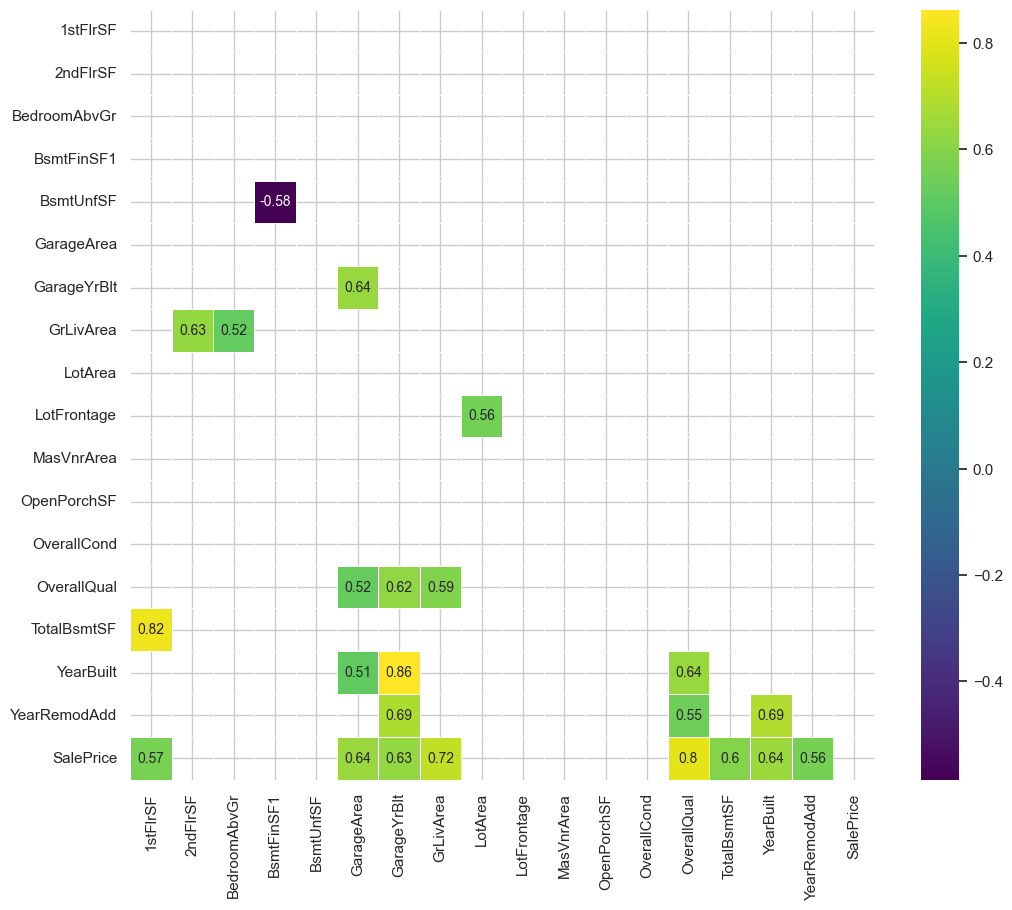



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



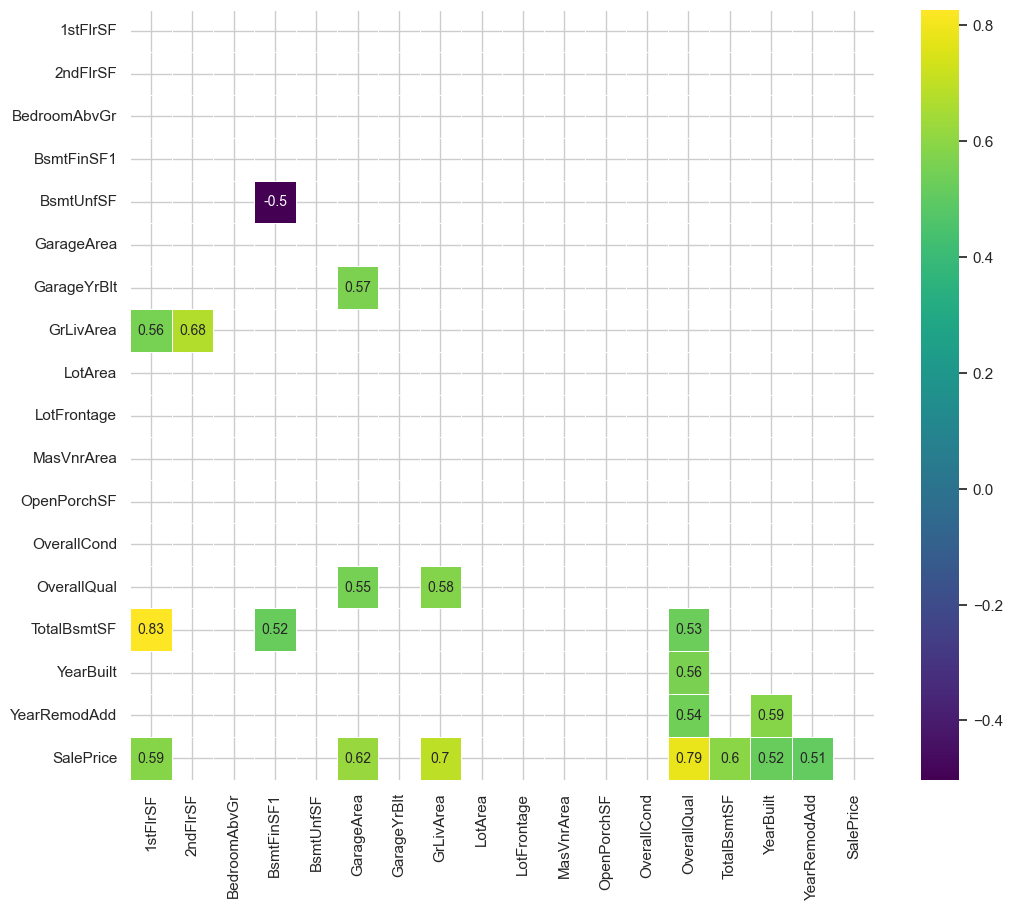



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



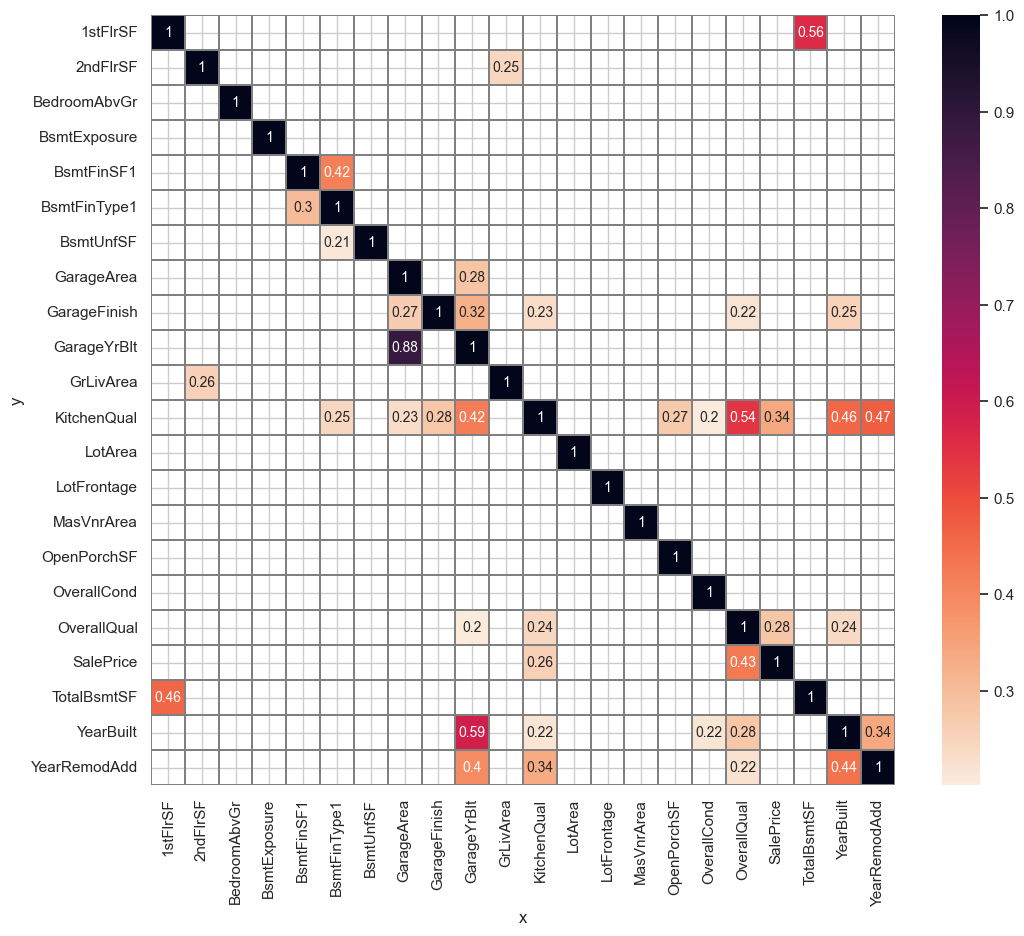

In [21]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.5, PPS_Threshold = 0.2,
                  figsize=(12,10), font_annot=10)

high_corr_features = df_corr_spearman['SalePrice'][df_corr_spearman['SalePrice'] > threshold].index.tolist()

#### Correlation Analysis: Before vs After Data Cleaning

After imputing missing values and removing sparse features, the correlation patterns shifted slightly. Spearman and Pearson scores remained largely stable for core predictive features, but Power Predictive Score (PPS) uncovered stronger signals in some imputed variables.

- Most top predictors maintained or slightly increased their correlation with `SalePrice`.
- **PPS scores** for some features (e.g., `OverallQual`, `YearBuilt`) improved post-cleaning, as imputed values allowed for clearer detection of predictive relationships.
- Features with poor data quality that might have introduced noise (e.g., `EnclosedPorch`, `WoodDeckSF`) were dropped, resulting in a clearer correlation structure.
- The rise in **maximum PPS score (0.702 → 0.885)** supports the notion that imputation helped uncover high-value relationships previously hidden due to missing data.

#### Updated Top Predictors of `SalePrice` (After Cleaning)

| Features most correlated with sales price | Spearman | Pearson  | PPS |
|-------------------------------------------|----------|----------|-----|
| `1stFlrSF`                                | ✅       | ✅      | ❌  |
| `GarageArea`                              | ✅       | ✅      | ❌  |
| `GarageYrBlt`                             | ✅       | ✅      | ❌  |
| `GrLivArea`                               | ✅       | ✅      | ❌  |
| `KitchenQual`                             | ✅       | ✅      | ✅  |
| `OverallQual`                             | ✅       | ✅      | ✅  |
| `TotalBsmtSF`                             | ✅       | ✅      | ❌  |
| `YearBuilt`                               | ✅       | ✅      | ✅  |
| `YearRemodAdd`                            | ✅       | ✅      | ❌  |

#### Key Differences from Original Correlation Check

| Feature        | Change Observed                            |
|----------------|--------------------------------------------|
| `KitchenQual`  | Now shows correlation in all three methods |
| `GarageYrBlt`  | Pearson correlation improved               |
| `YearBuilt`    | PPS score improved post-imputation         |
| `OverallQual`  | Consistently strong — remains top predictor|


---

# Save Cleaned Train and Test Sets

Here we create create outputs/datasets/collection folder

In [22]:
import os

try:
    os.makedirs("outputs/datasets/cleaned", exist_ok=True)
    df_method.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)
    TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)
except Exception as e:
    print(f"Error creating directories or saving files: {e}")

# Push cleaned data to Repo

You can now push the changes to your GitHub repository, using the Git commands (git add, git commit, git push).

## Conclusions and Next Steps

- Identified variables with missing data and evaluated their type and proportion.
- Dropped `EnclosedPorch` and `WoodDeckSF` due to sparsity and low predictive potential.
- Split dataset into training and testing subsets before applying any modeling logic.
- Saved cleaned datasets for reuse in the upcoming modeling notebook.

In the next notebook, we’ll:
- Impute remaining missing values
- Encode categorical features
- Perform feature scaling and model training
